# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Проект "Определение оптимального региона для разработки новых скважин"

# Цель
Определить регион, в котором добыча нефти принесет наибольшую прибыль, учитывая возможные риски.

# Задачи
1. Загрузить и подготовить данные о характеристиках скважин в трех регионах.
2. Обучить и проверить модель линейной регрессии для каждого региона, используя 75% данных для обучения и 25% для валидации.
3. Проанализировать результаты обучения моделей и сравнить средний запас предсказанного сырья и RMSE для каждого региона.
4. Подготовиться к расчету прибыли, сохранив ключевые значения и рассчитав достаточный объем сырья для безубыточной разработки новой скважины.
5. Написать функцию для расчета прибыли по выбранным скважинам и предсказаниям модели.
6. Применить технику Bootstrap с 1000 выборок для нахождения распределения прибыли в каждом регионе и определения средней прибыли, 95%-го доверительного интервала и риска убытков.
7. Предложить регион для разработки скважин, обосновав выбор на основе анализа рисков и прибыли.

# Условия
- Для обучения модели подходит только линейная регрессия.
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Доход с одной тысячи баррелей сырья составляет 450 тыс. рублей.
- После оценки рисков нужно оставить только те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.
- Данные синтетические, детали контрактов и характеристики месторождений не разглашаются. 



**Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.**

**Данные геологоразведки трёх регионов находятся в файлах:**

- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

**Признаки:**

- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)

**Целевой признак:**

- product — объём запасов в скважине (тыс. баррелей)

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm_notebook
from tqdm import tqdm
from tqdm import notebook
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
RANDOM_STATE = 42

In [4]:
try:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
    df3 = pd.read_csv('/datasets/geo_data_2.csv')
    
except:
    df1 = pd.read_csv('geo_data_0.csv')
    df2 = pd.read_csv('geo_data_1.csv')
    df3 = pd.read_csv('geo_data_2.csv')

In [5]:
def analyze(df, name):
    """
    Функция для анализа датафрейма
    :param df: датафрейм для анализа
    :param name: имя датафрейма
    """
    print(f"\nАнализ DataFrame: {name}\n")
    
    # 1. Общая информация о DataFrame
    print("Общая информация:")
    display(df.head())
    display(df.info())

    # 2. Описательная статистика
    print("Описательная статистика:")
    display(df.describe(include='all'))

    # 3. Анализ по каждому столбцу
    for col in df.columns:
        print('-' * 30)
        print(f"Анализ столбца: {col}")

        # 3.1 Тип данных и количество уникальных значений
        dtype = df[col].dtype
        num_unique = df[col].nunique()
        print(f"Тип данных: {dtype}, Количество уникальных значений: {num_unique}")

        # 3.2 Уникальные значения (отсортированные) - вывод только если мало уникальных значений
        if num_unique <= 20:
            unique_values = df[col].sort_values().unique()
            print(f"Уникальные значения: {unique_values}")
        elif num_unique <= 50:  # Вывод первых и последних 10 значений, если их не слишком много
            unique_values = df[col].sort_values().unique()
            print(f"Первые 10 уникальных значений: {unique_values[:10]}")
            print(f"Последние 10 уникальных значений: {unique_values[-10:]}")

        # 3.3 Количество и процент пропущенных значений (NaN, None)
        num_missing = df[col].isnull().sum()
        percent_missing = round(df[col].isnull().mean() * 100, 2)
        print(f"Количество пропущенных значений (NaN, None): {num_missing}, Процент: {percent_missing}%")

        # 3.4 Количество и процент нулевых значений - только для числовых
        if pd.api.types.is_numeric_dtype(dtype):
            num_zeros = (df[col] == 0).sum()
            percent_zeros = round(num_zeros / len(df) * 100, 2)
            print(f"Количество 0: {num_zeros}, Процент 0: {percent_zeros}%")

        # 3.5 Проверка пропусков для текстовых столбцов (пустые строки и пробелы)
        if pd.api.types.is_string_dtype(dtype):
            num_empty = (df[col] == "").sum() + (df[col] == " ").sum()
            percent_empty = round(num_empty / len(df) * 100, 2)
            print(f"Количество пустых строк и пробелов: {num_empty}, Процент: {percent_empty}%")

        print('-' * 30, "\n")

    # 4. Проверка полных дублей
    num_duplicates = df.duplicated().sum()
    percent_duplicates = round(num_duplicates / len(df) * 100, 2)
    print(f"Количество полных дублей: {num_duplicates}, Процент полных дублей: {percent_duplicates}%")


In [6]:
# функция, для создания графиков распределений 
def optimal_bins(data):
    """Вычисляет оптимальное количество корзин для гистограммы по правилу Стерджена."""
    n = len(data)
    return int(np.ceil(np.sqrt(n)))

# Функция для построения гистограмм и ящиков с усами
def plot_distribution(df, columns):
    """
    Строит гистограммы и ящики с усами для указанных столбцов датафрейма.
    Оптимальное количество корзин вычисляется по правилу Стерджена.
    """
    num_cols = len(columns)
    sns.set(style="whitegrid")  # Настройка стиля графиков
    fig, axes = plt.subplots(num_cols, 2, figsize=(14, 5 * num_cols))
    
    if num_cols == 1:
        axes = [axes]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Цвета для различных столбцов
    for i, col in enumerate(columns):
        # Оптимальное количество корзин
        bins = optimal_bins(df[col])
        
        # Гистограмма
        hist_data = df[col]
        sns.histplot(hist_data, bins=bins, kde=True, ax=axes[i, 0], color=colors[i], edgecolor='black')
        
        # Добавление средних и медианных линий
        mean = hist_data.mean()
        median = hist_data.median()
        axes[i, 0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
        axes[i, 0].axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
        
        # Оформление графика
        axes[i, 0].set_title(f'Гистограмма распределения: {col}', fontsize=14)
        axes[i, 0].set_xlabel(col, fontsize=12)
        axes[i, 0].set_ylabel('Частота', fontsize=12)
        axes[i, 0].legend()
        axes[i, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Ящик с усами
        sns.boxplot(x=hist_data, ax=axes[i, 1], color=colors[i])
        axes[i, 1].set_title(f'Ящик с усами: {col}', fontsize=14)
        axes[i, 1].set_xlabel(col, fontsize=12)
        axes[i, 1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


In [7]:
def corr_matrix(data):    
    corr_matrix = data.corr()
    display(corr_matrix)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()

In [8]:
# Функция для обучения и проверки модели
def train_and_evaluate_model(X, y, name):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    mae = mean_absolute_error(y_val, predictions)

    print(f"\nРезультаты для региона {name}:")
    print(f"Средний запас предсказанного сырья: {predictions.mean():.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}\n")

    return predictions, y_val


In [9]:
analyze(df1, 'geo_data_0.csv')


Анализ DataFrame: geo_data_0.csv

Общая информация:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Описательная статистика:


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,74z30,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


------------------------------
Анализ столбца: id
Тип данных: object, Количество уникальных значений: 99990
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f0
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f1
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f2
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------

In [10]:
analyze(df2, 'geo_data_1.csv')


Анализ DataFrame: geo_data_1.csv

Общая информация:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Описательная статистика:


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,bfPNe,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


------------------------------
Анализ столбца: id
Тип данных: object, Количество уникальных значений: 99996
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f0
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f1
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f2
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------

In [11]:
analyze(df3, 'geo_data_2.csv')


Анализ DataFrame: geo_data_2.csv

Общая информация:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Описательная статистика:


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,KUPhW,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


------------------------------
Анализ столбца: id
Тип данных: object, Количество уникальных значений: 99996
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f0
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f1
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: f2
Тип данных: float64, Количество уникальных значений: 100000
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------

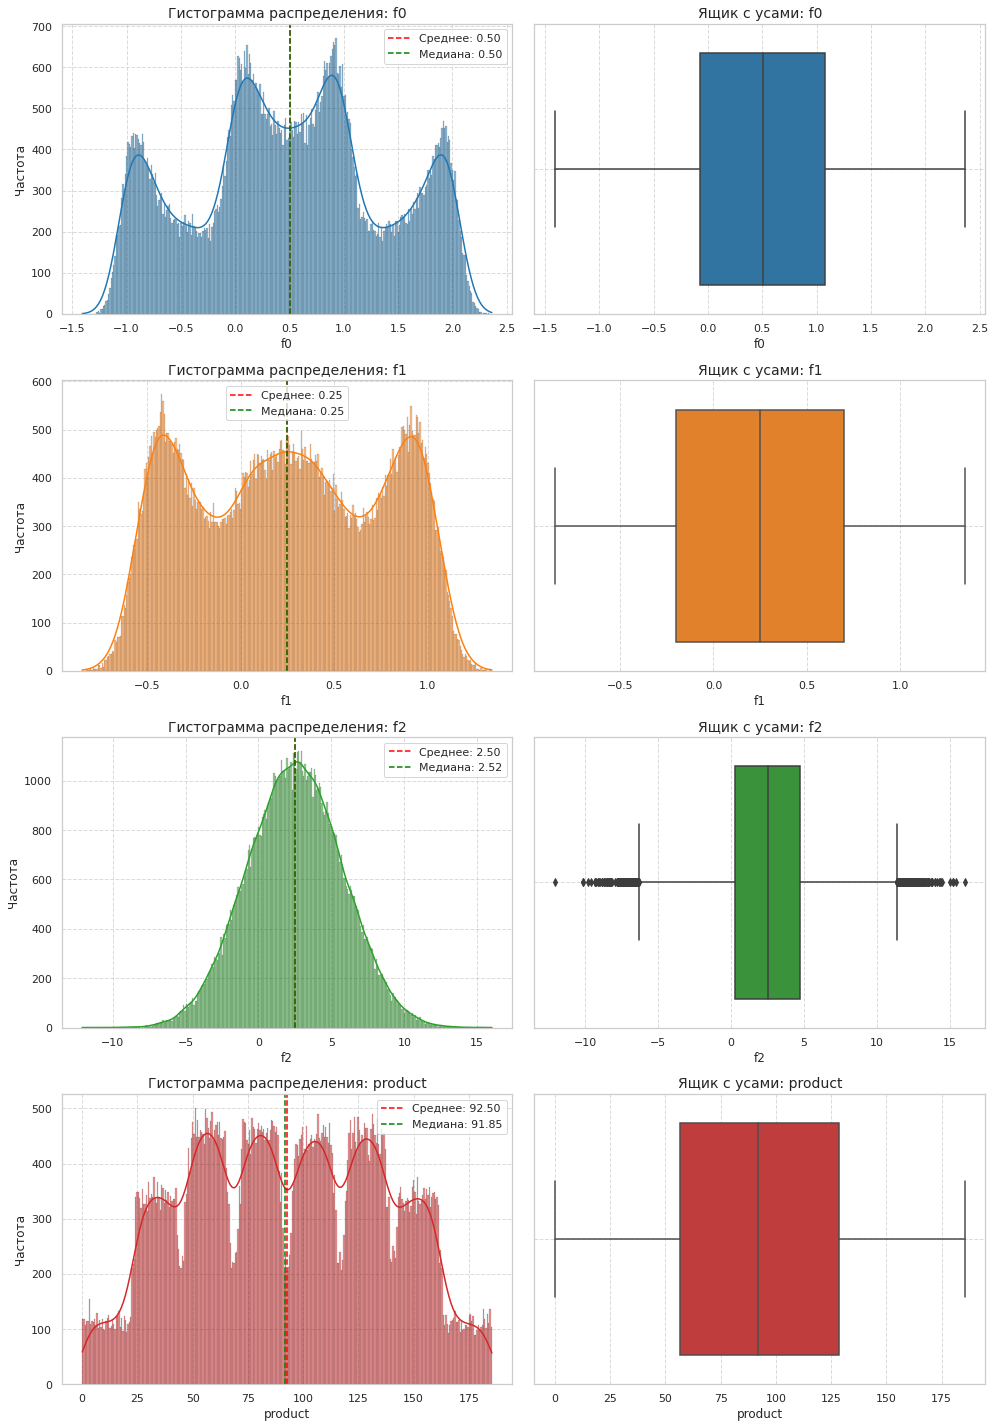

In [12]:
# Построение графиков для выбранных столбцов
columns_to_analyze = [
    'f0',
    'f1',
    'f2',
    'product'
]


plot_distribution(df1, columns_to_analyze)

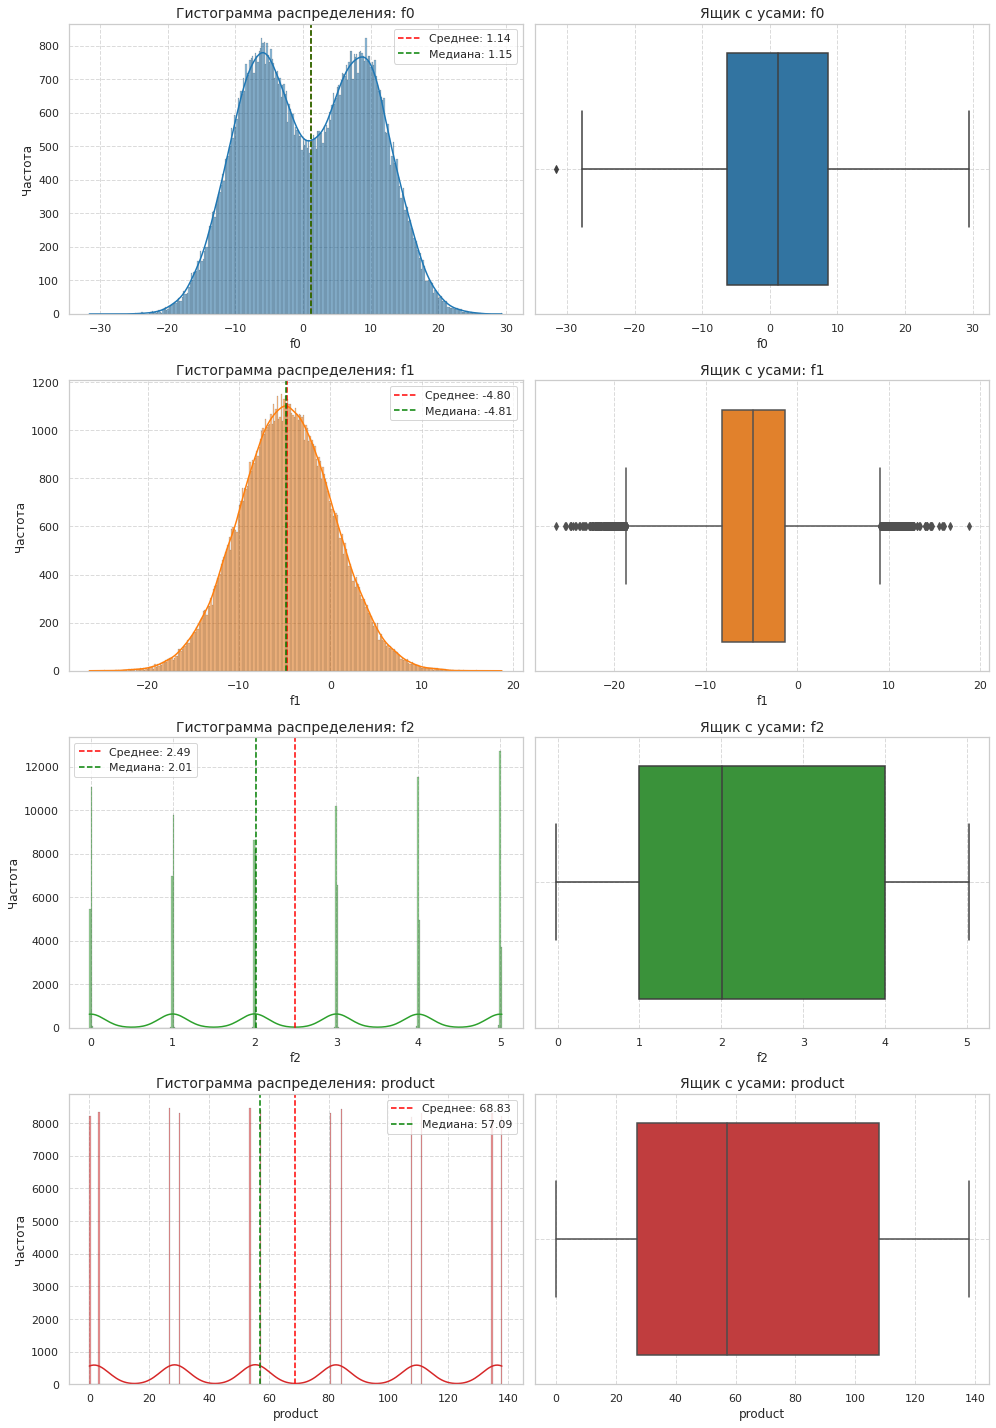

In [13]:
plot_distribution(df2, columns_to_analyze)

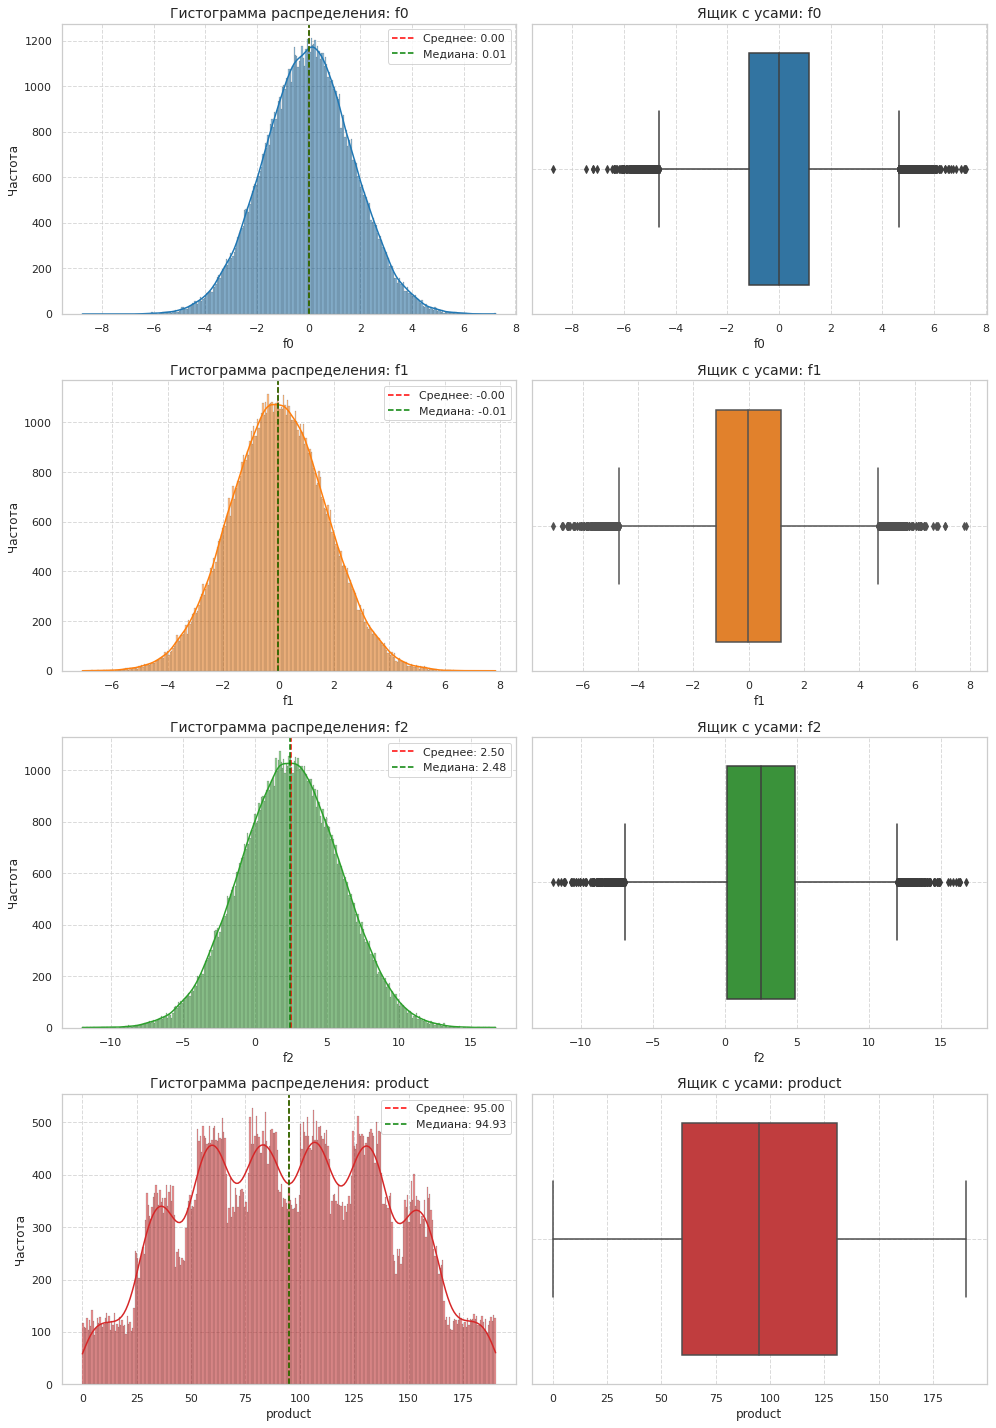

In [14]:
plot_distribution(df3, columns_to_analyze)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


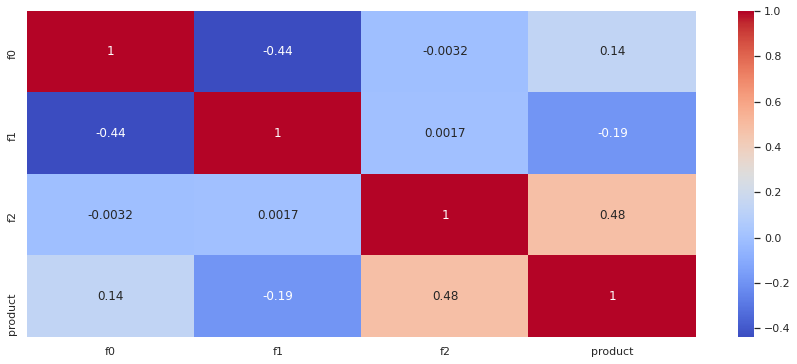

In [15]:
corr_matrix(df1)

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


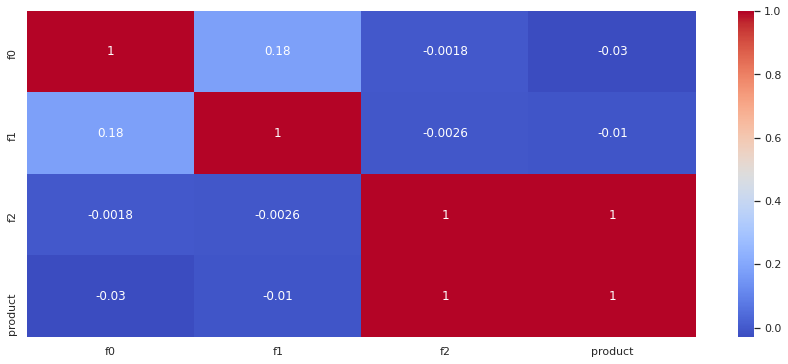

In [16]:
corr_matrix(df2)

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


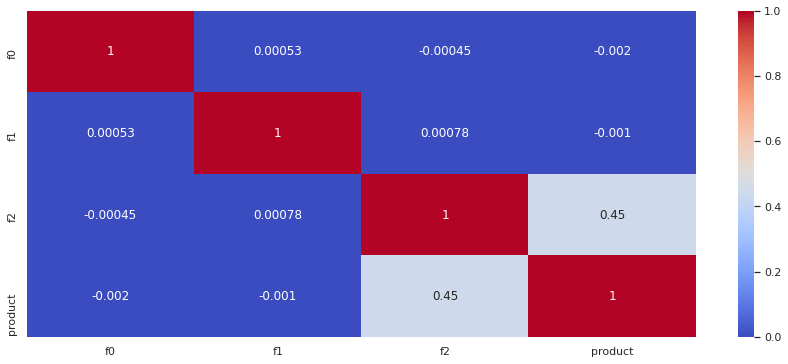

In [17]:
corr_matrix(df3)

После анализа dataframes geo_data_0, geo_data_1 и geo_data_2 можно сделать следующие выводы:

- Все dataframes содержат 100000 строк и 5 столбцов: 'id', 'f0', 'f1', 'f2' и 'product'. 


- Тип данных для столбцов 'f0', 'f1', 'f2' и 'product' — float64, а для столбца 'id' — object. 


- Количество уникальных значений для столбца 'id' в каждом dataframe составляет 99990, 99996 и 99996 соответственно.


- Количество пропущенных значений в каждом dataframe равно 0 для всех столбцов.

- **product:**
   *   В geo_data_1 наблюдается значительное количество нулевых значений (8.24%).
    В geo_data_0 и geo_data_2 присутствует только по одному нулевому значению.
   * В geo_data_0 содержит уникальные значения, начиная от 0 до 185.364347, в geo_data_1 — от 0 до 137.945408, а в geo_data_2 — от 0 до 190.029838. Это указывает на различный диапазон значений запасов сырья в каждом регионе.
   * В 'geo_data_1.csv' примечательно мало уникальных значений(только 12), что указывает на наличие большого количества повторяющихся значений. 
   * Средний объем добычи сырья в geo_data_0 и geo_data_2 близки (около 92 и 95 единиц), а в geo_data_1 значительно меньше (около 69 единиц).


- Матрицы корреляции для каждого dataframe показывают, что между feature-столбцами есть определенные корреляции. В geo_data_0 и geo_data_2 наибольшая корреляция наблюдается между 'f2' и 'product' (0.483663 и 0.445871 соответственно), а в geo_data_1 — между 'f2' и 'product' (0.999397).



## Обучение и проверка модели

In [18]:
targets = {}
names = ['df1', 'df2', 'df3']
data = [df1, df2, df3]

for i, (df, name) in enumerate(zip(data, names)):
    X = df[['f0', 'f1', 'f2']]
    y = df['product']

    predictions_ml, y_val_ml = train_and_evaluate_model(X, y, name)
    # запишем фактические данные и предсказанные в словарь
    targets[names[i]] = (y_val_ml, pd.Series(predictions_ml, index=y_val_ml.index, name='product_predicted'))


Результаты для региона df1:
Средний запас предсказанного сырья: 92.40
RMSE: 37.76
MAE: 31.05


Результаты для региона df2:
Средний запас предсказанного сырья: 68.71
RMSE: 0.89
MAE: 0.72


Результаты для региона df3:
Средний запас предсказанного сырья: 94.77
RMSE: 40.15
MAE: 32.90



В данной части работы мы провели обучение и проверку модели.

Результаты экспериментов показали, что RMSE (корень из среднеквадратичной ошибки) для датасета df2 составляет 0.89. 

Однако, для датасетов df1 и df2, RMSE значительно выше и составляет 37.76 и 40.15 соответственно. Это говорит о том, что в этих датасетах имеется большой разброс данных в целевых показателях, что означает, что предсказанные значения не отражают реальные запасы сырья с высокой точностью.

## Подготовка к расчёту прибыли

In [19]:
POINTS = 500 # количество скважин, которое исследуют при разведке региона
BEST_FOR_ML = 200 # количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения
BUDGET = 10e9 # бюджет (расходы) на разработку скважин в регионе (тыс. рублей), заложенный на 200 скважин
BARREL_PRICE = 450e3 # доход с каждой единицы продукта (тыс. рублей на 1 тыс. баррелей)
THRESHOLD = 0.025


In [20]:
names = ['df1', 'df2', 'df3']
data = [df1, df2, df3]

break_even = BUDGET / (BARREL_PRICE * BEST_FOR_ML)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even:.2f} тыс. баррелей.')

for name, data in zip(names, data):
    print()
    print(f'Средний запас в {name} регионе = {data["product"].mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше чем порог = {len(data.query("product > @break_even")) / len(data):.2%}')
    print(f'Количество скважин в объёмом больше чем порог = {len(data.query("product > @break_even"))}')

Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в df1 регионе = 92.50 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 36.58%
Количество скважин в объёмом больше чем порог = 36583

Средний запас в df2 регионе = 68.83 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 16.54%
Количество скважин в объёмом больше чем порог = 16537

Средний запас в df3 регионе = 95.00 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 38.18%
Количество скважин в объёмом больше чем порог = 38178


На этапе подготовки расчета прибыли было определено, что достаточный объём сырья для безубыточной разработки в каждом регионе составляет 111.11 тыс. баррелей.

* geo_data_0 содержит 35.58% скважин с запасами нефти более 111 тысяч баррель.
* geo_data_1 содержит 16.54% скважин с запасами нефти более 111 тысяч баррель.
* geo_data_2 содержит 38.18% скважин с запасами нефти более 111 тысяч баррель.

## Расчёт прибыли и рисков 


Регион df1:


  0%|          | 0/1000 [00:00<?, ?it/s]

Средняя прибыль: 400464812.25 тыс. рублей
95%-й доверительный интервал: [-1.10060265e+08  8.97150988e+08]
Вероятность убытков: 6.40%

Регион df2:


  0%|          | 0/1000 [00:00<?, ?it/s]

Средняя прибыль: 433329726.72 тыс. рублей
95%-й доверительный интервал: [6.16316098e+07 8.13084899e+08]
Вероятность убытков: 1.00%

Регион df3:


  0%|          | 0/1000 [00:00<?, ?it/s]

Средняя прибыль: 374071097.83 тыс. рублей
95%-й доверительный интервал: [-1.47954495e+08  8.69976283e+08]
Вероятность убытков: 8.20%


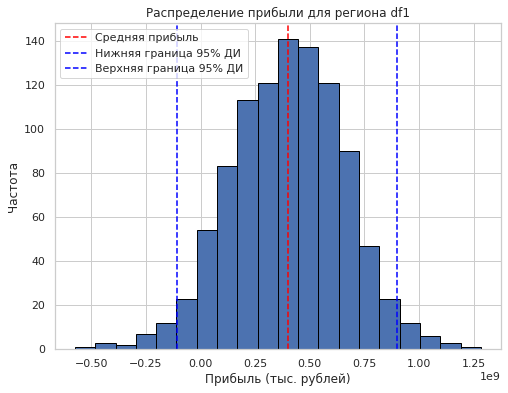

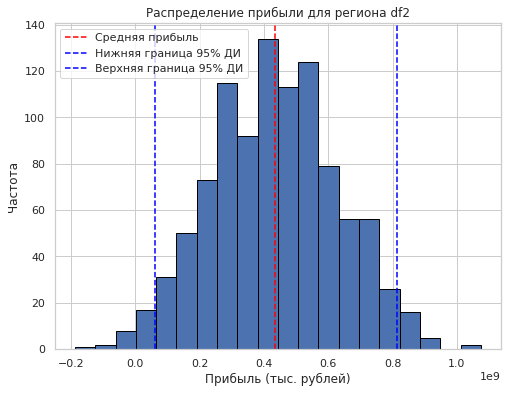

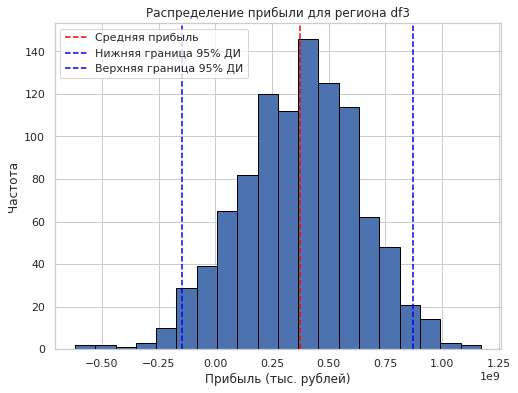

In [21]:
# Функция для расчета прибыли
def calculate_profit(predictions, target_values):
    best_wells = predictions.sort_values(ascending=False).index[:BEST_FOR_ML]  # Выбираем 200 лучших скважин
    total_product = target_values.loc[best_wells].sum()  # Суммируем добычу по 200 лучшим
    profit = total_product * BARREL_PRICE - BUDGET  # Расчет прибыли
    return profit


# Проводим bootstrap-анализ для оценки рисков и прибыли
results = {}
for name, (y_val, predictions) in targets.items():
    print(f'\nРегион {name}:')
    profits = []
    for i in notebook.tqdm(range(1000)):
        # Выбираем случайную выборку без повторений
        sample_indices = np.random.choice(y_val.index, size=POINTS, replace=False)  
        sample_predictions = predictions.loc[sample_indices]  # Выбираем прогнозы для этой выборки
        sample_target_values = y_val.loc[sample_indices]  # Выбираем реальные значения для этой выборки

        # Рассчитываем прибыль для этой выборки
        profit = calculate_profit(sample_predictions, sample_target_values)  #  
        profits.append(profit)

    # Вычисляем среднюю прибыль, 95% доверительный интервал и риск убытков
    mean_profit = np.mean(profits)
    # Используем numpy.percentile для вычисления границ 95% ДИ
    confidence_interval = np.percentile(profits, [2.5, 97.5]) 
    loss_risk = (np.array(profits) < 0).mean()

    print(f"Средняя прибыль: {mean_profit:.2f} тыс. рублей")
    print(f"95%-й доверительный интервал: {confidence_interval}")
    print(f"Вероятность убытков: {loss_risk:.2%}")

    # Добавляем список прибылей в результаты
    results[name] = {'mean_profit': mean_profit, 'confidence_interval': confidence_interval, 'loss_risk': loss_risk, 'profits': profits}

for name, data in results.items():
    plt.figure(figsize=(8, 6))
    plt.hist(data['profits'], bins=20, edgecolor='black')
    plt.title(f'Распределение прибыли для региона {name}')
    plt.xlabel('Прибыль (тыс. рублей)')
    plt.ylabel('Частота')

    plt.axvline(data['mean_profit'], color='red', linestyle='--', label='Средняя прибыль')
    plt.axvline(data['confidence_interval'][0], color='blue', linestyle='--', label='Нижняя граница 95% ДИ')
    plt.axvline(data['confidence_interval'][1], color='blue', linestyle='--', label='Верхняя граница 95% ДИ')

    plt.legend()
    plt.show()

In [22]:
# Вывод рекомендаций по выбору региона
filtered_results = {name: result for name, result in results.items() if result['loss_risk'] < THRESHOLD}

if filtered_results:
    best_region = max(filtered_results, key=lambda x: filtered_results[x]['mean_profit'])
    print(f"\nРекомендуемый регион для разработки скважин: {best_region}")
    print(f"Обоснование: наименьший риск убытков ({results[best_region]['loss_risk']:.2%}) и наибольшая средняя прибыль ({results[best_region]['mean_profit']:.2f} тыс. рублей).")
else:
    print("\nНет регионов с вероятностью убытков ниже 2.5%.")



Рекомендуемый регион для разработки скважин: df2
Обоснование: наименьший риск убытков (1.00%) и наибольшая средняя прибыль (433329726.72 тыс. рублей).


В регионе df2 ожидается наибольшая возможная прибыль в размере 433329726.72 тыс. рублей при оценке модели.
Риск потерь минимальный - всего 1.00%.


**Вывод и рекомендации по выбору региона**
- В ходе проделанной работы была построена модель машинного обучения для предсказания запасов нефти в трех регионах. - Проведен анализ рисков и прибыли с использованием техники Bootstrap.

**Результаты исследования:**

- Модель линейной регрессии: показала удовлетворительные результаты для региона df2 с низким RMSE и MAE, что говорит о высокой точности предсказаний.
- Bootstrap-анализ: выявил, что регион df2 имеет наибольшую среднюю прибыль (433329726.72 тыс. рублей) и минимальный риск убытков (1.00%).
- Сравнение регионов: регион df1 и df3 демонстрируют более высокий риск убытков (6.40% и 8.20% соответственно), несмотря на сопоставимую среднюю прибыль.

**Рекомендация:**

Рекомендуется выбрать регион df2 для разработки новых скважин, так как он обладает наилучшим соотношением риска и прибыли. Низкий риск убытков и высокая средняя прибыль делают его наиболее привлекательным вариантом для инвестиций.